### RQ1 you can find in relative directory, it is a webscraping tool
1. External functions must have their own files .py and then imported in this main notebook
2. Upload notebook with cells already run before handing in the HW
3. Add to readme.md the link to the notebook as well

### RQ2 2.1

In [ ]:
import os
import pandas as pd
import json
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


In [ ]:

import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_query(query):
    query = query.lower()
    query = re.sub(r'[^\w\s]', '', query)
    tokens = [stemmer.stem(word) for word in query.split() if word not in stop_words]
    return tokens

def load_index(vocab_file, index_file):
    vocab_df = pd.read_csv(vocab_file)
    vocabulary = dict(zip(vocab_df['term'], vocab_df['term_id']))

    with open(index_file, 'r') as f:
        inverted_index = json.load(f)

    return vocabulary, inverted_index

def execute_conjunctive_query(query, vocabulary, inverted_index, folder_path):
    #preprocess the query
    query_terms = preprocess_query(query)
    print(f"Query terms after preprocessing: {query_terms}")

    #find the term_ids for each query term
    term_ids = [vocabulary.get(term) for term in query_terms if term in vocabulary]
    term_ids = [term_id for term_id in term_ids if term_id is not None]
    print(f"term_id found in query: {term_ids}")

    if not term_ids:
        print("No query terms found in the vocabulary.")
        return []

    #find doc_ids that contain all term_ids
    doc_sets = [set(inverted_index[str(term_id)]) for term_id in term_ids if str(term_id) in inverted_index]
    common_docs = set.intersection(*doc_sets) if doc_sets else set()
    print(f"doc_id comuni trovati: {common_docs}")

    #collect restaurant details for found doc_ids
    results = []
    for doc_id in common_docs:
        file_path = os.path.join(folder_path, f"{doc_id}.tsv")
        df = pd.read_csv(file_path, sep='\t')
        restaurant_info = {
            "restaurantName": df['restaurantName'].iloc[0],
            "address": df['address'].iloc[0],
            "description": df['description'].iloc[0],
            "website": df['website'].iloc[0]
        }
        results.append(restaurant_info)

    #creating the results DataFrame
    results_df = pd.DataFrame(results, columns=["restaurantName", "address", "description", "website"])
    return results_df

if __name__ == "__main__":
    vocab_file = "vocabulary.csv"  #vocabulary path
    index_file = "inverted_index.json"  #inverted index path
    folder_path = "processed_files"

    vocabulary, inverted_index = load_index(vocab_file, index_file)

    #prompts the user for the query
    query = input("Enter your query: ")
    results_df = execute_conjunctive_query(query, vocabulary, inverted_index, folder_path)

    #show results
    if not results_df.empty:
        print(results_df)
    else:
        print("No results found for the given query.")

### Output 2.1.2, restaurants which contains requested query

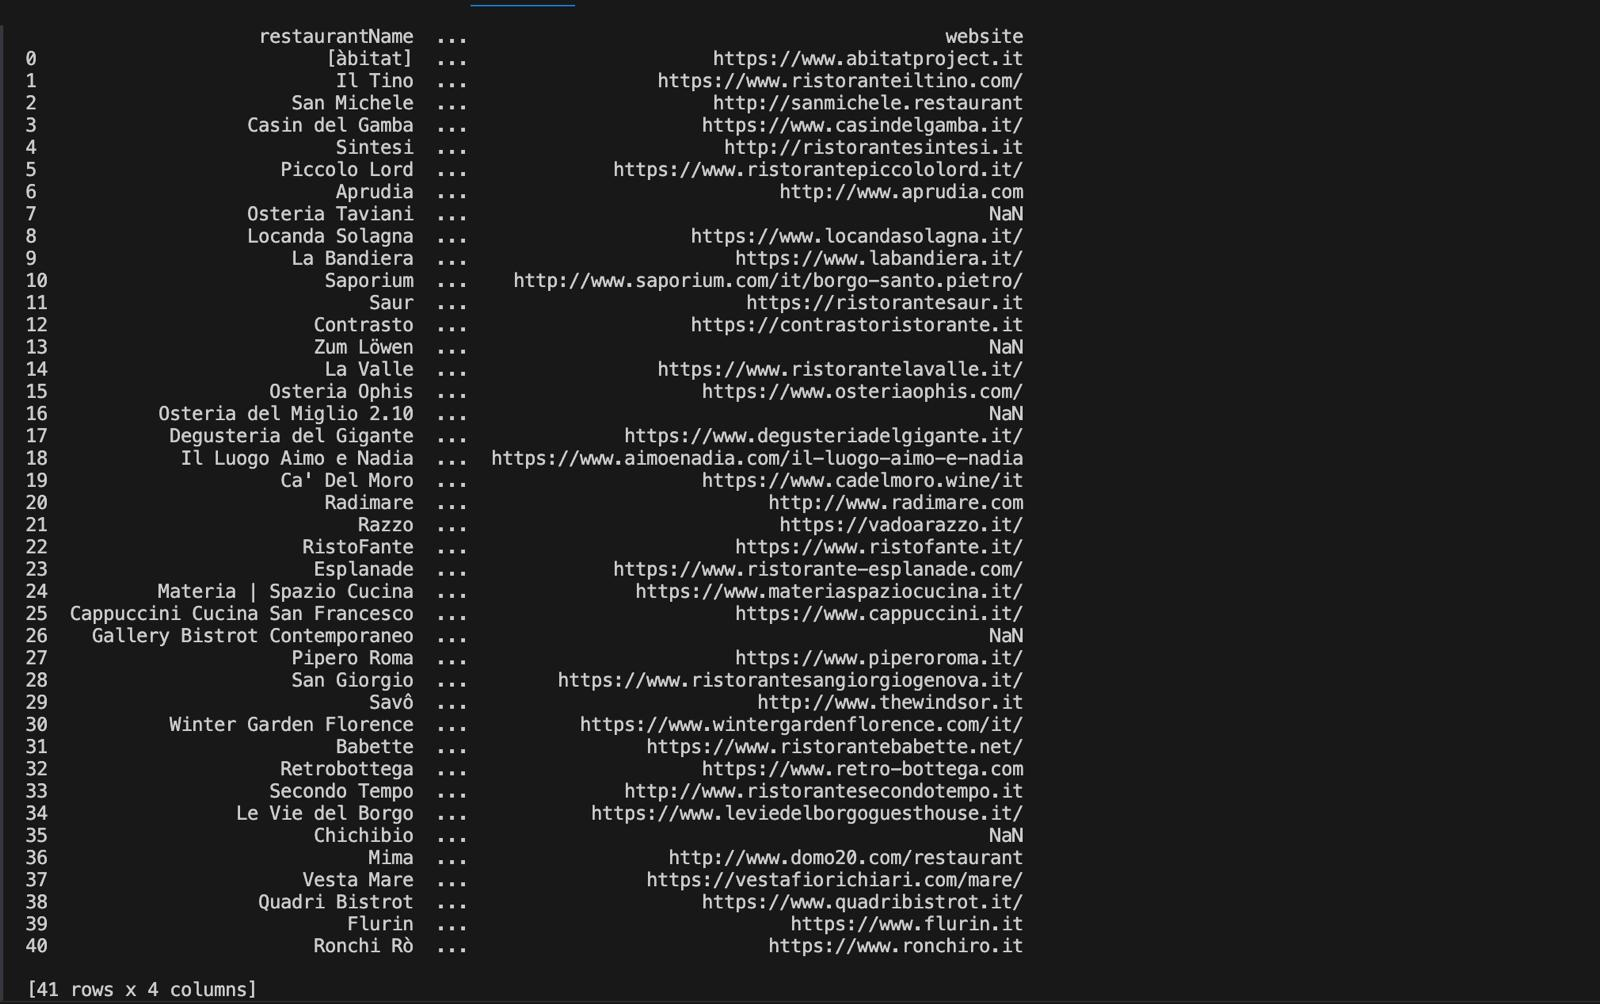

### 2.2.1 Exercise

In [ ]:
import os
import pandas as pd
import json
import math
from collections import defaultdict, Counter

def calculate_tf_idf(folder_path, output_index_file):
    #dictionaries for TF and count of documents containing each term
    term_doc_freq = defaultdict(int)  #document count for each term
    doc_term_freq = {}
    total_docs = 0
    total_terms = 0
    unique_terms = set()  #set to track unique terms

    #calculating frequencies
    print("Start processing documents...")
    for filename in os.listdir(folder_path):
        if filename.endswith(".tsv"):
            file_path = os.path.join(folder_path, filename)
            doc_id = filename.split('.')[0]

            df = pd.read_csv(file_path, sep='\t')
            if 'processed_description' in df.columns:
                description = df['processed_description'].iloc[0]

                #tokenize the description and count the frequency of the terms
                terms = description.split()
                total_terms += len(terms)  #add the number of terms
                term_freq = Counter(terms)
                doc_term_freq[doc_id] = term_freq  #save TF for this document
                total_docs += 1

                #increase the document count for each term and add unique terms
                for term in term_freq.keys():
                    term_doc_freq[term] += 1
                    unique_terms.add(term)

    print(f"Total documents processed: {total_docs}")
    print(f"Total words processed: {total_terms}")
    print(f"Total number of unique terms in the vocabulary: {len(unique_terms)}")

    #calculate TF-IDF and construct the inverted index
    print("Calculating TF-IDF scores and constructing the inverted index...")
    tfidf_index = defaultdict(list)
    for doc_id, term_freq in doc_term_freq.items():
        norm_factor = math.sqrt(sum((tf / sum(term_freq.values())) ** 2 for tf in term_freq.values()))  #normalization
        for term, tf in term_freq.items():
            #calculate TF (term frequency / total terms in document)
            tf_value = tf / sum(term_freq.values())
            #calculate IDF (logarithm of total number of documents divided by documents containing the term)
            idf_value = math.log(total_docs / (1 + term_doc_freq[term]))
            #calculate TF-IDF
            tfidf_score = tf_value * idf_value
            #normalize TF-IDF
            tfidf_score /= norm_factor if norm_factor > 0 else 1

            tfidf_index[term].append((doc_id, tfidf_score))

    print("Inverted index with TF-IDF successfully constructed")

    #saves inverted index with TF-IDF
    with open(output_index_file, 'w') as f:
        json.dump(tfidf_index, f, indent=4)

    print(f"Inverted index with TF-IDF saved in {output_index_file}")

if __name__ == "__main__":
    folder_path = "processed_files"
    output_index_file = "tfidf_inverted_index.json"  #output file

    calculate_tf_idf(folder_path, output_index_file)

### 2.2.2

In [ ]:
import os
import pandas as pd
import json
import math
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import defaultdict

import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_query(query):
    query = query.lower()
    query = re.sub(r'[^\w\s]', '', query)
    tokens = [stemmer.stem(word) for word in query.split() if word not in stop_words]
    return tokens
#calculate TF-IDF vector for query terms
def calculate_query_tfidf(query_terms, vocabulary, inverted_index, total_docs):
    query_tf = defaultdict(int)
    for term in query_terms:
        query_tf[term] += 1

    query_tfidf = {}
    norm_factor = 0  #normalization factor for query vector
    for term, tf in query_tf.items():
        # TF for query
        tf_value = tf / len(query_terms)
        # IDF for query
        idf_value = math.log(total_docs / (1 + len(inverted_index.get(term, []))))
        tfidf_score = tf_value * idf_value
        query_tfidf[term] = tfidf_score
        norm_factor += tfidf_score ** 2
    #vector normalization
    norm_factor = math.sqrt(norm_factor)
    for term in query_tfidf:
        query_tfidf[term] /= norm_factor if norm_factor > 0 else 1

    return query_tfidf
#calculate the cosine similarity between the query vector and a document vector
def cosine_similarity(query_vector, doc_vector):
    dot_product = sum(query_vector[term] * doc_vector.get(term, 0) for term in query_vector)
    query_norm = math.sqrt(sum(value ** 2 for value in query_vector.values()))
    doc_norm = math.sqrt(sum(value ** 2 for value in doc_vector.values()))
    if query_norm == 0 or doc_norm == 0:
        return 0.0
    return dot_product / (query_norm * doc_norm)

def execute_ranked_query(query, vocabulary, inverted_index, folder_path, total_docs, k):
    #preprocess la query
    query_terms = preprocess_query(query)
    print(f"Query terms after preprocessing: {query_terms}")

    #filter terms not present in the index
    query_terms = [term for term in query_terms if term in inverted_index]
    if not query_terms:
        print("No query terms found in index.")
        return pd.DataFrame()

    #calculate the vector TF-IDF for query
    query_tfidf = calculate_query_tfidf(query_terms, vocabulary, inverted_index, total_docs)
    print(f"TF-IDF vector of the query (normalized): {query_tfidf}")

    #calculate the cosine similarity for each document that contains at least one query term
    doc_scores = {}
    for term in query_terms:
        for doc_id, tfidf_score in inverted_index[term]:
            if doc_id not in doc_scores:
                doc_scores[doc_id] = defaultdict(float)
            doc_scores[doc_id][term] = tfidf_score

    #calculate the cosine similarity between the query and each document
    results = []
    for doc_id, doc_vector in doc_scores.items():
        similarity = cosine_similarity(query_tfidf, doc_vector)
        if similarity > 0:
            results.append((doc_id, similarity))
            print(f"Document: {doc_id}, Similarity: {similarity}")

    #sort results by similarity and return top-k
    results = sorted(results, key=lambda x: x[1], reverse=True)[:k]

    #collect restaurant details for found doc_ids
    restaurant_results = []
    for doc_id, score in results:
        file_path = os.path.join(folder_path, f"{doc_id}.tsv")
        df = pd.read_csv(file_path, sep='\t')
        restaurant_info = {
            "restaurantName": df['restaurantName'].iloc[0],
            "address": df['address'].iloc[0],
            "description": df['description'].iloc[0],
            "website": df['website'].iloc[0],
            "similarity_score": score
        }
        restaurant_results.append(restaurant_info)

    #creating the results DataFrame
    results_df = pd.DataFrame(restaurant_results, columns=["restaurantName", "address", "description", "website", "similarity_score"])
    return results_df

if __name__ == "__main__":

    vocab_file = "vocabulary.csv"  #vocabulary path
    index_file = "tfidf_inverted_index.json"  #inverted index with TF-IDF path
    folder_path = "processed_files"  #input files

    #load vocabulary and index inverted
    with open(index_file, 'r') as f:
        inverted_index = json.load(f)
    total_docs = len(os.listdir(folder_path))

    #prompts the user for the query
    query = input("Enter your query: ")
    k = int(input("Enter the number of top-k results to display: "))
    results_df = execute_ranked_query(query, None, inverted_index, folder_path, total_docs, k)

    #show results
    if not results_df.empty:
        print(results_df)
    else:
        print("No results found for the given query.")

### output 2.2.2
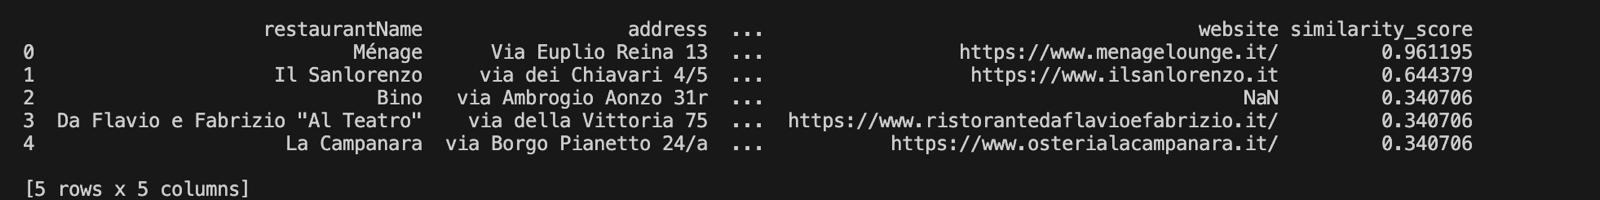

### 3 exercise

In [ ]:
import os
import pandas as pd
import json
import math
import re
import heapq
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import defaultdict

import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Preprocess la query
def preprocess_query(query):
    query = query.lower()
    query = re.sub(r'[^\w\s]', '', query)
    tokens = [stemmer.stem(word) for word in query.split() if word not in stop_words]
    return tokens

def load_index(vocab_file, index_file):
    vocab_df = pd.read_csv(vocab_file)
    vocabulary = dict(zip(vocab_df['term'], vocab_df['term_id']))  # Convert the vocabulary into a dictionary

    with open(index_file, 'r') as f:
        inverted_index = json.load(f)

    return vocabulary, inverted_index

def execute_conjunctive_query(query, vocabulary, inverted_index, folder_path):
    query_terms = preprocess_query(query)
    term_ids = [vocabulary.get(term) for term in query_terms if term in vocabulary]
    term_ids = [term_id for term_id in term_ids if term_id is not None]

    if not term_ids:
        print("No query terms found in the vocabulary.")
        return []

    doc_sets = [set(inverted_index[str(term_id)]) for term_id in term_ids if str(term_id) in inverted_index]
    common_docs = set.intersection(*doc_sets) if doc_sets else set()

    results = []  # Collect restaurant details
    for doc_id in common_docs:
        file_path = os.path.join(folder_path, f"{doc_id}.tsv")
        df = pd.read_csv(file_path, sep='\t')
        restaurant_info = {
            "restaurantName": df['restaurantName'].iloc[0],
            "address": df['address'].iloc[0],
            "description": df['description'].iloc[0],
            "website": df['website'].iloc[0],
            "doc_id": doc_id
        }
        results.append(restaurant_info)
    return results

def calculate_query_tfidf(query_terms, vocabulary, inverted_index, total_docs):
    query_tf = defaultdict(int)
    for term in query_terms:
        query_tf[term] += 1

    query_tfidf = {}
    norm_factor = 0
    for term, tf in query_tf.items():
        tf_value = tf / len(query_terms)
        idf_value = math.log(total_docs / (1 + len(inverted_index.get(term, []))))
        tfidf_score = tf_value * idf_value
        query_tfidf[term] = tfidf_score
        norm_factor += tfidf_score ** 2

    norm_factor = math.sqrt(norm_factor)
    for term in query_tfidf:
        query_tfidf[term] /= norm_factor if norm_factor > 0 else 1

    return query_tfidf

def cosine_similarity(query_vector, doc_vector):
    dot_product = sum(query_vector[term] * doc_vector.get(term, 0) for term in query_vector)
    query_norm = math.sqrt(sum(value ** 2 for value in query_vector.values()))
    doc_norm = math.sqrt(sum(value ** 2 for value in doc_vector.values()))
    if query_norm == 0 or doc_norm == 0:
        return 0.0
    return dot_product / (query_norm * doc_norm)

def execute_ranked_query(query, vocabulary, inverted_index, folder_path, total_docs, k):
    query_terms = preprocess_query(query)
    query_terms = [term for term in query_terms if term in inverted_index]
    if not query_terms:
        print("No query terms found in index.")
        return pd.DataFrame()

    query_tfidf = calculate_query_tfidf(query_terms, vocabulary, inverted_index, total_docs)
    doc_scores = {}
    for term in query_terms:
        for doc_id, tfidf_score in inverted_index[term]:
            if doc_id not in doc_scores:
                doc_scores[doc_id] = defaultdict(float)
            doc_scores[doc_id][term] = tfidf_score

    results = []
    for doc_id, doc_vector in doc_scores.items():
        similarity = cosine_similarity(query_tfidf, doc_vector)
        if similarity > 0:
            results.append((doc_id, similarity))
    # Sort results by similarity and return top-k
    results = sorted(results, key=lambda x: x[1], reverse=True)[:k]

    restaurant_results = []
    for doc_id, score in results:
        file_path = os.path.join(folder_path, f"{doc_id}.tsv")
        df = pd.read_csv(file_path, sep='\t')
        restaurant_info = {
            "restaurantName": df['restaurantName'].iloc[0],
            "address": df['address'].iloc[0],
            "description": df['description'].iloc[0],
            "website": df['website'].iloc[0],
            "similarity_score": score
        }
        restaurant_results.append(restaurant_info)

    results_df = pd.DataFrame(restaurant_results, columns=["restaurantName", "address", "description", "website", "similarity_score"])
    return results_df

def custom_score(restaurant, description_score, query_terms):
    description_weight = 0.45  # Weight for description
    cuisine_weight = 0.30  # Weight for the type of cuisine
    facilities_weight = 0.05  # Weight for services
    price_weight = 0.20  # Weight for the price range

    # Initialize the score with the description similarity
    score = description_score * description_weight

    # Added score for cuisine type
    cuisine_types = str(restaurant.get('cuisineType', '')).lower().split(',')
    cuisine_matches = sum(1 for term in query_terms if term in cuisine_types)
    if cuisine_matches > 0:
        score += (cuisine_matches / len(query_terms)) * cuisine_weight

    # Added score for services
    facilities = str(restaurant.get('facilitiesServices', '')).lower()
    facilities_matches = sum(1 for term in query_terms if term in facilities)
    if facilities_matches > 0:
        score += (facilities_matches / len(query_terms)) * facilities_weight

    # Price preference keyword Lists
    cheap_terms = ["cheap", "affordable", "budget", "low-cost", "inexpensive", "economical", "reasonably priced"]
    moderate_terms = ["moderate", "average", "mid-range", "fair-priced", "decent"]
    expensive_terms = ["expensive", "premium", "high-end", "luxury", "upscale", "costly", "exclusive", "top-tier"]

    # Price range score based on query preferences
    price_score = 0
    price = restaurant.get('priceRange', '')

    if any(term in query_terms for term in cheap_terms):
        if '€' in price:
            price_score += 2
        elif '€€' in price:
            price_score += 1

    elif any(term in query_terms for term in moderate_terms):
        if '€€' in price or '€€€' in price:
            price_score += 2
        else:
            price_score += 1

    elif any(term in query_terms for term in expensive_terms):
        if '€€€' in price or '€€€€' in price:
            price_score += 2
        elif '€€' in price:
            price_score += 1

    score += price_score * price_weight

    return round(score, 2)

def execute_custom_ranked_query(query, vocabulary, inverted_index, folder_path, total_docs, k):
    query_terms = preprocess_query(query)
    query_terms = [term for term in query_terms if term in inverted_index]
    if not query_terms:
        print("No query terms found in index.")
        return pd.DataFrame()

    query_tfidf = calculate_query_tfidf(query_terms, vocabulary, inverted_index, total_docs)
    doc_scores = {}
    for term in query_terms:
        for doc_id, tfidf_score in inverted_index[term]:
            if doc_id not in doc_scores:
                doc_scores[doc_id] = defaultdict(float)
            doc_scores[doc_id][term] = tfidf_score

    #use a heap to keep the top-k restaurants
    heap = []
    for doc_id, doc_vector in doc_scores.items():
        similarity = cosine_similarity(query_tfidf, doc_vector)
        if similarity > 0:
            file_path = os.path.join(folder_path, f"{doc_id}.tsv")
            df = pd.read_csv(file_path, sep='\t')
            restaurant_name = str(df['restaurantName'].iloc[0])
            address = str(df['address'].iloc[0])
            description = str(df['description'].iloc[0])
            website = str(df['website'].iloc[0]) if 'website' in df.columns else "N/A"
            price_range = str(df["priceRange"].iloc[0]) if "priceRange" in df.columns else "N/A"
            cuisine_type = str(df["cuisineType"].iloc[0]) if "cuisineType" in df.columns else "N/A"
            facilities_services = str(df["facilitiesServices"].iloc[0]) if "facilitiesServices" in df.columns else "N/A"

            #create restaurant object and calculate custom score
            restaurant = {
                "restaurantName": restaurant_name,
                "address": address,
                "description": description,
                "website": website,
                "priceRange": price_range,
                "cuisineType": cuisine_type,
                "facilitiesServices": facilities_services,
            }
            description_score = similarity
            score = float(custom_score(restaurant, description_score, query_terms))

            #push the tuple (score, details) into the heap
            heap_entry = (score, restaurant_name, address, description, website)
            if len(heap) < k:
                heapq.heappush(heap, heap_entry)
            else:
                heapq.heappushpop(heap, heap_entry)

    #extract the top-k results in descending order of scores
    top_k_results = sorted(heap, key=lambda x: -x[0])  #sort by score in descending order

    #create the final results list
    results = []
    for entry in top_k_results:
        score, restaurant_name, address, description, website = entry
        results.append({
            "restaurantName": restaurant_name,
            "address": address,
            "description": description,
            "website": website,
            "custom_score": score,
        })

    return pd.DataFrame(results, columns=["restaurantName", "address", "description", "website", "custom_score"])


if __name__ == "__main__":
    vocab_file = "vocabulary.csv"
    index_file = "tfidf_inverted_index.json"
    folder_path = "processed_files"

    vocabulary, inverted_index = load_index(vocab_file, index_file)
    total_docs = len(os.listdir(folder_path))

    query = input("Enter your query: ")
    k = int(input("Enter the number of top-k results to display: "))
    results_df = execute_custom_ranked_query(query, vocabulary, inverted_index, folder_path, total_docs, k)

    if not results_df.empty:
        print(results_df)
        results_df.to_csv("top_k_restaurants.csv", index=False)  #for RQ4
        print("Results saved in 'top_k_restaurants.csv'")
    else:
        print("No results found for the given query.")



### Ex 3 output

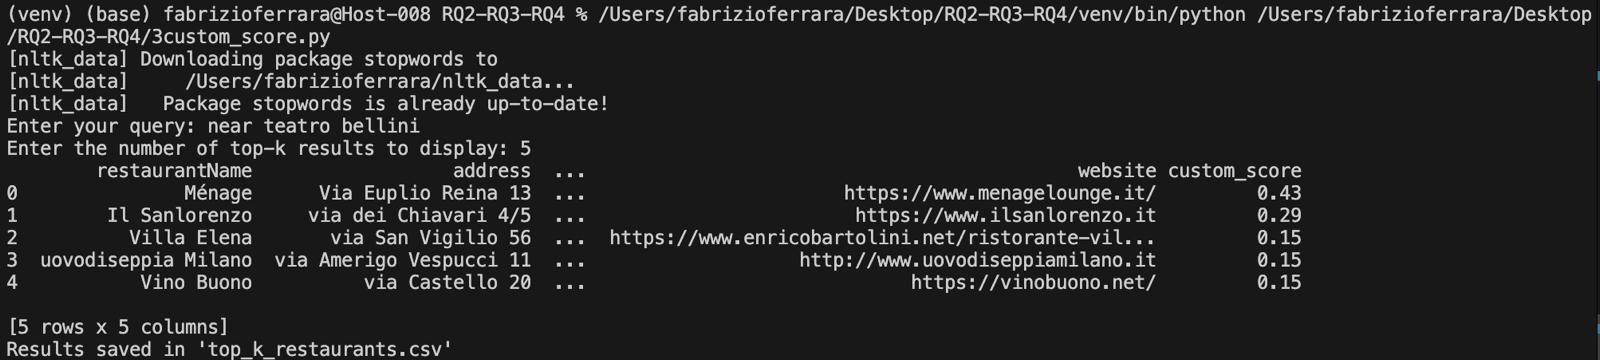

### Ex 3 explanation
The results of the two codes are different because they use different approaches.
The first method (**RQ2.2.2**) is simpler and is based only on restaurant descriptions.
This makes it very precise when the query terms are present in the descriptions, but it does not take into account other aspects.
The second method (**RQ3**), on the other hand, is more complete because it also considers other factors,
such as price, services and type of cuisine.
This makes it more useful for those who have more specific preferences or want a more personalized result.
The first method is based only on the matching of the terms in the description, so it is simple but can be limited.
The second method also considers other aspects such as price, services and type of cuisine, providing more complete results.
However, it may penalize restaurants with very relevant descriptions if they do not meet other criteria of the query.

### RQ4 is in repository RQ2-RQ3-RQ4